In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the classes and create the data loader

In [3]:
classes = [0, 4, 9]

dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [4]:
def class_to_class_index_tensor(c):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

### Create the model

In [5]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1
model = image_unet.LabelGuidedMNISTUNetTimeConcat(
    len(classes) + 1, t_limit=t_limit
    # Add 1 here to prepare for adding a new digit class later
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/mnist_continuous_049_labelguided"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

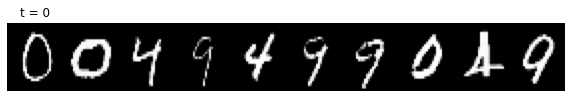

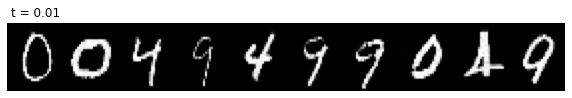

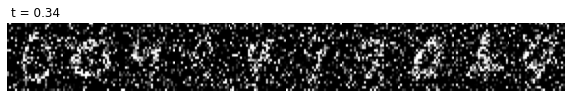

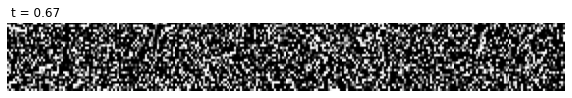

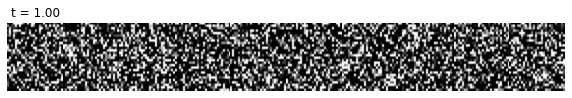

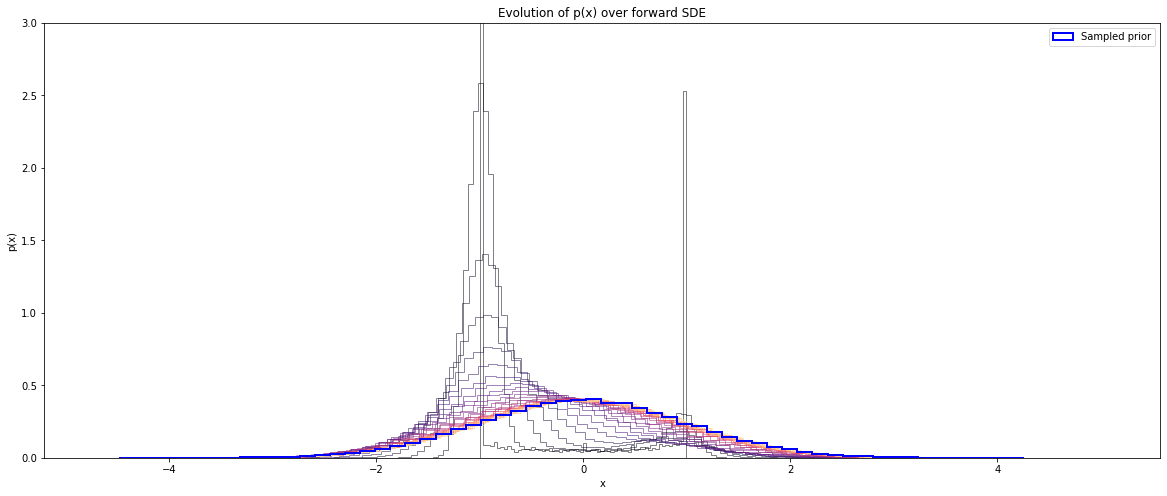

In [6]:
# Show some images after running the SDE forward for different times
time_steps = 4

x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()

plot_mnist_digits(x0, grid_size=(10, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.linspace(0.01, t_limit, time_steps):
    xt, score = sde.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_mnist_digits(xt.cpu().numpy(), grid_size=(10, 1), title=("t = %.2f" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

### Show generated digits

In [7]:
train_continuous_model.train_ex.run(
    "train_label_guided_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_to_class_index": class_to_class_index_tensor,
        "num_epochs": 30,
        "learning_rate": 0.001,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "1"
Loss: 123.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 27.60it/s]


Epoch 1 average Loss: 372.11


Loss: 66.88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:03<00:00, 36.88it/s]


Epoch 2 average Loss: 115.48


Loss: 60.76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 29.08it/s]


Epoch 3 average Loss: 90.83


Loss: 68.76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.62it/s]


Epoch 4 average Loss: 76.32


Loss: 44.88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 29.36it/s]


Epoch 5 average Loss: 69.13


Loss: 48.50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.29it/s]


Epoch 6 average Loss: 61.58


Loss: 40.30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 28.19it/s]


Epoch 7 average Loss: 59.01


Loss: 43.67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.98it/s]


Epoch 8 average Loss: 56.57


Loss: 63.88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 27.31it/s]


Epoch 9 average Loss: 54.02


Loss: 62.07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.70it/s]


Epoch 10 average Loss: 50.37


Loss: 37.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 27.90it/s]


Epoch 11 average Loss: 49.40


Loss: 43.07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 32.38it/s]


Epoch 12 average Loss: 48.58


Loss: 39.23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 28.08it/s]


Epoch 13 average Loss: 47.20


Loss: 73.43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 29.22it/s]


Epoch 14 average Loss: 45.00


Loss: 46.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 27.68it/s]


Epoch 15 average Loss: 45.07


Loss: 79.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.18it/s]


Epoch 16 average Loss: 45.74


Loss: 39.47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 25.47it/s]


Epoch 17 average Loss: 45.12


Loss: 36.43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 28.65it/s]


Epoch 18 average Loss: 44.36


Loss: 44.86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 27.21it/s]


Epoch 19 average Loss: 43.61


Loss: 40.89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.73it/s]


Epoch 20 average Loss: 41.96


Loss: 44.35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.80it/s]


Epoch 21 average Loss: 42.23


Loss: 34.60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 29.22it/s]


Epoch 22 average Loss: 41.15


Loss: 39.25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.34it/s]


Epoch 23 average Loss: 40.88


Loss: 37.15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.23it/s]


Epoch 24 average Loss: 40.78


Loss: 42.25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.00it/s]


Epoch 25 average Loss: 40.41


Loss: 46.65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 27.59it/s]


Epoch 26 average Loss: 39.35


Loss: 44.68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 30.38it/s]


Epoch 27 average Loss: 40.96


Loss: 38.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 28.42it/s]


Epoch 28 average Loss: 38.72


Loss: 34.75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 26.13it/s]


Epoch 29 average Loss: 38.47


Loss: 25.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 27.13it/s]
INFO - train - Completed after 0:02:31


Epoch 30 average Loss: 37.89


Sampling class: 0


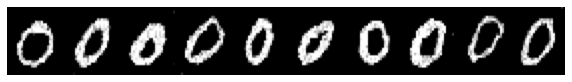

Sampling class: 4


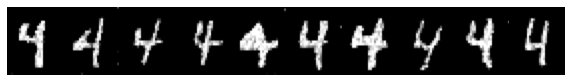

Sampling class: 9


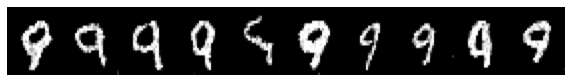

In [8]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        model, sde, class_to_sample, class_to_class_index_tensor,
        sampler="pc", t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)